# Importing libriries : 

In [26]:
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet50
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score,roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [27]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Data Displaying

In [28]:
images = []

In [29]:
image_files = [
    "../data/baseball/00000001.jpg",
    "../data/chess/00000009.png",
    "../data/formula1/00000004.jpg",
    "../data/badminton/00000007.png",
    "../data/tennis/00000026.jpg",
    "../data/gymnastics/00000010.jpg",
    "../data/ice_hockey/00000008.jpg",
    "../data/motogp/00000016.jpg",
    "../data/boxing/00000012.jpg",
    "../data/swimming/00000011.jpg"
]

for img_path in image_files:
    if os.path.exists(img_path):
        images.append(mpimg.imread(img_path))
    else:
        print("File not found:", img_path)

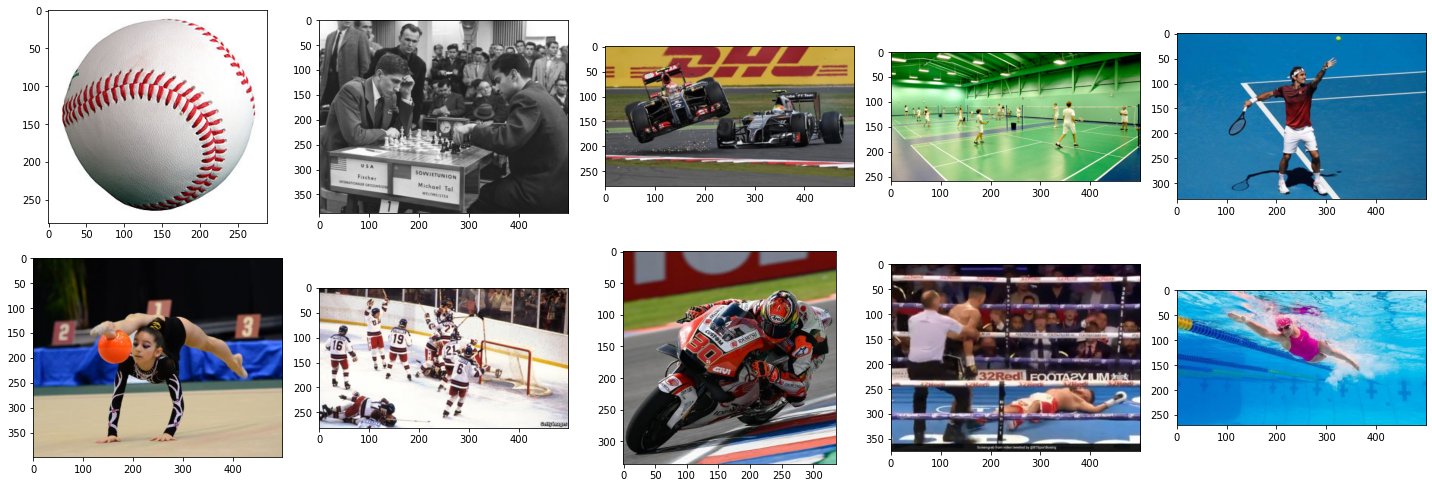

In [30]:
plt.figure(figsize=(20, 10))
columns = 5

for i, image in enumerate(images[:10]):
    plt.subplot(len(images[:10]) // columns + 1, columns, i + 1)
    plt.imshow(image)

plt.tight_layout()
plt.show()

# Filtring the data : 

In [32]:
Sport_Labels = set(['boxing', 'swimming', 'table_tennis'])
print("Images are being loaded ... ")   
datapath = '../data'
pathToImages = list(paths.list_images(datapath))
data = []
labels = []
image
for image_path in pathToImages:
    label = image_path.split(os.path.sep)[-2]
    if label not in Sport_Labels:
        continue
    image = cv2.imread(image_path)
    print(image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (244, 244))
    data.append(image)
    labels.append(label)

Images are being loaded ... 
(281, 500, 3)
(293, 500, 3)
(281, 500, 3)
(285, 500, 3)
(375, 500, 3)
(333, 500, 3)
(280, 500, 3)
(333, 500, 3)
(305, 500, 3)
(375, 500, 3)
(281, 500, 3)
(280, 500, 3)
(270, 480, 3)
(373, 500, 3)
(334, 499, 3)
(281, 499, 3)
(333, 500, 3)
(281, 500, 3)
(333, 500, 3)
(262, 500, 3)
(329, 500, 3)
(280, 500, 3)
(280, 500, 3)
(281, 500, 3)
(333, 500, 3)
(303, 450, 3)
(281, 500, 3)
(281, 500, 3)
(296, 500, 3)
(266, 499, 3)
(281, 500, 3)
(281, 500, 3)
(382, 500, 3)
(281, 500, 3)
(333, 500, 3)
(275, 499, 3)
(281, 500, 3)
(395, 500, 3)
(296, 500, 3)
(333, 499, 3)
(375, 500, 3)
(281, 499, 3)
(329, 500, 3)
(216, 384, 3)
(281, 500, 3)
(316, 500, 3)
(312, 500, 3)
(281, 500, 3)
(345, 500, 3)
(250, 500, 3)
(262, 500, 3)
(332, 500, 3)
(275, 500, 3)
(375, 500, 3)
(332, 500, 3)
(339, 500, 3)
(333, 500, 3)
(333, 500, 3)
(333, 500, 3)
(351, 499, 3)
(283, 500, 3)
(352, 500, 3)
(281, 500, 3)
(296, 500, 3)
(206, 364, 3)
(281, 500, 3)
(281, 500, 3)
(343, 500, 3)
(335, 500, 3)
(266,

In [33]:
image.shape

(244, 244, 3)

In [34]:
data = np.array(data)
labels = np.array(labels)

In [35]:
lb = label_binarize(labels, classes=list(Sport_Labels))
class_labels = list(Sport_Labels) 
labels = torch.tensor(lb, dtype=torch.float32)

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.25, stratify=labels, random_state=42)

In [37]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [38]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[123.68/255.0, 116.779/255.0, 103.939/255.0], std=[1, 1, 1]),
])

In [39]:
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[123.68/255.0, 116.779/255.0, 103.939/255.0], std=[1, 1, 1]),
])

In [40]:
train_dataset = CustomDataset(X_train, Y_train, transform=train_transform)
test_dataset = CustomDataset(X_test, Y_test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [41]:
class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()
        self.base_model = resnet50(pretrained=True)
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()
        self.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.base_model(x)
        out = self.fc(features)
        return out

In [42]:
model = ResNetModel(num_classes=len(Sport_Labels))
for param in model.base_model.parameters():
    param.requires_grad = False

# Optimizer and Loss Function
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [43]:
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss / len(train_loader)}")

In [46]:
num_epochs = 1
train(model, train_loader, criterion, optimizer, num_epochs=num_epochs)

Epoch [1/1] Loss: 0.9866215717792511


In [59]:
print(X_train[0].shape)

(244, 244, 3)


In [15]:
torch.save(model.state_dict(), 'outputmodel.pth')

In [16]:
import pickle
with open('label_binarizer.pkl', 'wb') as f:
    pickle.dump(lb, f)

In [72]:
import json
lb_list = lb.tolist()
with open('label_binarizer.json', 'w') as f:
    json.dump(lb_list, f)

In [17]:
# Loading the model and label binarizer
model = ResNetModel(num_classes=len(Sport_Labels))
model.load_state_dict(torch.load('outputmodel.pth'))
model.eval()

ResNetModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [18]:
with open('label_binarizer.pkl', 'rb') as f:
    lb = pickle.load(f)

In [36]:
capture_video = cv2.VideoCapture('./How to swim.mp4')
outputvideo = 'output_video.avi'
writer = None
(Width, Height) = (None, None)
mean = torch.tensor([123.68/255.0, 116.779/255.0, 103.939/255.0]).unsqueeze(0).unsqueeze(2).unsqueeze(3)

queue = deque(maxlen=128)

In [37]:
font = cv2.FONT_HERSHEY_SIMPLEX
font_size = 1.25
font_thickness = 2
text_color = (255, 255, 255)  # White color
text_background_color = (0, 0, 0)  # Black background color
text_opacity = 0.7  # Adjust the opacity of the text

while True:
    (taken, frame) = capture_video.read()
    if not taken:
        break
    if Width is None or Height is None:
        (Height, Width) = frame.shape[:2]

    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (244, 244)).astype("float32") / 255.0
    frame = torch.tensor(frame.transpose(2, 0, 1)).unsqueeze(0)
    frame -= mean
    with torch.no_grad():
        frame = model(frame)
    queue.append(frame.cpu().numpy())
    results = np.array(queue).mean(axis=0)
    i = np.argmax(results)
    label = class_labels[i]  # Use the stored class labels for inference
    text = f"Sport: {label}"

    # Draw background rectangle
    cv2.rectangle(output, (30, 40), (400, 80), text_background_color, -1)

    # Draw text on the video
    cv2.putText(output, text, (45, 70), font, font_size, text_color, font_thickness, cv2.LINE_AA)

    # Make the text blend with the frame
    cv2.addWeighted(output, text_opacity, output, 1 - text_opacity, 0, output)

    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter(outputvideo, fourcc, 30, (Width, Height), True)
    writer.write(output)
    cv2.imshow("In progress", output)
    key = cv2.waitKey(1) & 0xFF

    if key == ord("q"):
        break

KeyboardInterrupt: 

In [38]:
print("Finalizing...")
writer.release()
capture_video.release()
cv2.destroyAllWindows()

Finalizing...
